In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_nv with different $\sigma$, $v$

In [ ]:
def bayes_noise(obs, noise_n=0, noise_e=0, seed=0):
    rng = np.random.RandomState(seed=seed)
    expectation = 0
    for o in range(len(obs)):
        weight = 1/(o+3)
        dW = rng.uniform((1-noise_n)*weight, (1+noise_n)*weight)
        weight = dW
        weight = np.clip(weight, 0, 1)
        error = obs[o] - expectation
        expectation += weight * error
        dE = rng.uniform((1-noise_e)*expectation, (1+noise_e)*expectation)
        expectation = dE
        expectation = np.clip(expectation, -1, 1)
    weight_ideal = 1/(o+3)
    expectation_ideal = bayes_ideal(obs)
    return weight_ideal, weight, expectation_ideal, expectation

In [2]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [3]:
sid = 18
sigmas = [0.025, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL with different $neurons$

In [2]:
def run_NEFRL(sid, n_neurons, n_error, n_learning):
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    trials = human['trial'].unique() 
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    for trial in trials:
        print(f"n_neurons {n_neurons}, n_error {n_error}, n_learning {n_learning}, sid {sid}, trial {trial}")
        env = Environment(dataset="carrabin", sid=sid, trial=trial, decay="stages", s=[mu,mu,mu,mu,mu])
        seed_net = sid + 1000*trial
        net = build_network_RL(env, n_neurons=n_neurons, n_error=n_error, n_learning=n_learning, seed_net=seed_net, z=0, a=5e-5)
        sim = nengo.Simulator(net, seed=trial, progress_bar=False)
        with sim:
            sim.run(env.Tall, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = sim.data[net.probe_value][tidx][0]
            df = pd.DataFrame([['NEF_RL', sid, trial, stage, qid, response]], columns=columns)
            dfs.append(df)
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['n_neurons'] = n_neurons
    dynamics_data['n_error'] = n_error
    dynamics_data['n_learning'] = n_learning
    return dynamics_data

In [3]:
def process_plot(human, NEFRL_data):
    human['n_neurons'] = 'human'
    human['n_error'] = 'human'
    human['n_learning'] = 'human'
    combined = pd.concat([human, NEFRL_data], ignore_index=True)
    combined['alpha'] = None
    combined['excursion'] = None
    for i, row in combined.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        qid = row['qid']
        n_neurons = row['n_neurons']
        n_error = row['n_error']
        n_learning = row['n_learning']
        response = row['response']
        avg_response = combined.query("type==@mt & n_neurons==@n_neurons & n_error==@n_error & n_learning==@n_learning & qid==@qid")['response'].mean()
        combined.at[i, 'excursion'] = response - avg_response
        if stage>1:
            stage_old = stage - 1
            response_old = combined.query("type==@mt & trial==@trial & n_neurons==@n_neurons & n_error==@n_error & n_learning==@n_learning & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
    # plot learning rates on left
    sns.kdeplot(combined, x='alpha', hue='n_learning', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    # plot excursions on right
    sns.kdeplot(combined, x='excursion', hue='n_learning', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)
    axes[0][0].set(title='Distribution of Behavioral Learning Rates')
    axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
    axes[1][0].set(xlabel="Learning Rate")
    axes[1][1].set(ylabel=None, xlabel='Excursion')
    plt.tight_layout()
    plt.show()

In [ ]:
sid = 18

# n_neurons = [50, 200]
n_error = [50, 200]
n_learning = [50, 200]
n = 100
e = 100
l = 100
dfs = []
# for n in n_neurons:
for e in n_error:
    for l in n_learning:
        dfs.append(run_NEFRL(sid, n, e, l))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

In [ ]:
process_plot(human, NEFRL_data)

## Load and Plot

In [4]:
noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13.pkl")
human = pd.read_pickle("data/carrabin.pkl").query("sid==18")

In [5]:
for i, row in noise_data.iterrows():
    mt = row['type']
    trial = row['trial']
    stage = row['stage']
    qid = row['qid']
    n_learning = row['n_learning']
    n_error = row['n_error']
    response = row['response']
    avg_response = noise_data.query("type==@mt & n_learning==@n_learning & n_error==@n_error & qid==@qid")['response'].mean()
    noise_data.at[i, 'excursion'] = response - avg_response
    if stage>1:
        stage_old = stage - 1
        response_old = noise_data.query("type==@mt & trial==@trial & n_error==@n_error & n_learning==@n_learning & stage==@stage_old")['response'].to_numpy()[0]
        delta = response_old - response
        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
        prediction_error = color - response_old
        alpha = np.abs(delta / prediction_error)
        noise_data.at[i, 'alpha'] = alpha

noise_data.to_pickle("data/noise_RL_data_expanded.pkl")

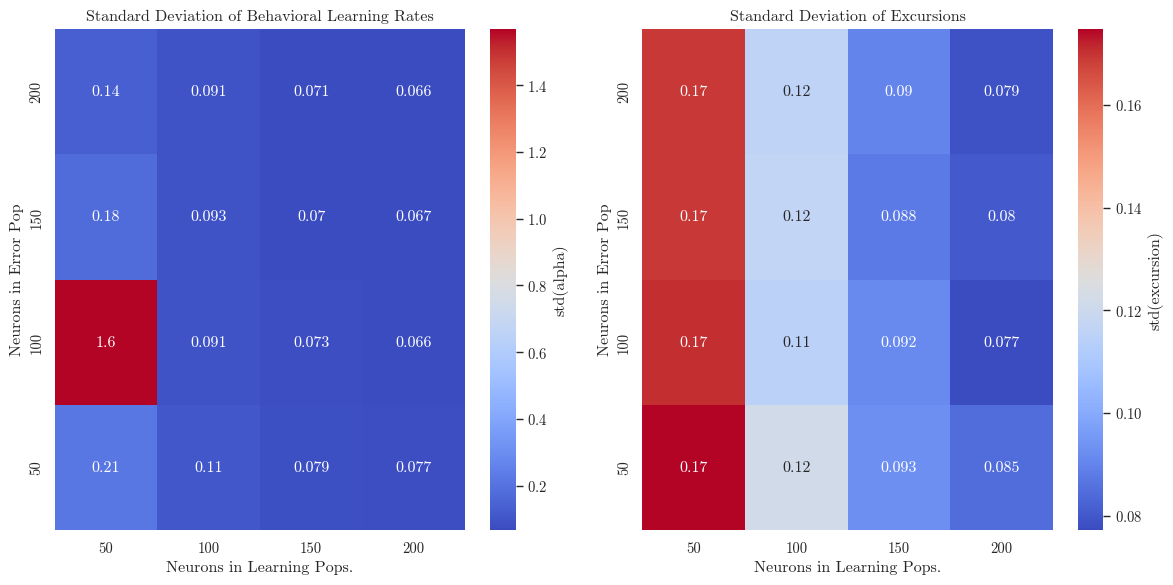

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
error_number = noise_data.pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc=np.std)
error_expectation = noise_data.pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc=np.std)
sns.heatmap(data=error_number, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(alpha)'}, ax=axes[0])
sns.heatmap(data=error_expectation, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(excursion)'}, ax=axes[1])
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].set(xlabel="Neurons in Learning Pops.", ylabel="Neurons in Error Pop", title="Standard Deviation of Behavioral Learning Rates")
axes[1].set(xlabel="Neurons in Learning Pops.", ylabel="Neurons in Error Pop", title="Standard Deviation of Excursions")
plt.tight_layout()
fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)

In [18]:
pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13.pkl")['qid'].unique()

array(['1', '11', '111', '1110', '11101', '0', '00', '001', '0010',
       '00100', '01', '010', '0101', '01011', '1111', '11110', '110',
       '1101', '11011', '000', '0000', '00001', '10', '101', '1011',
       '10111', '00000', '0100', '01000', '0011', '00111', '011', '0110',
       '01101', '11111', '0001', '00010', '100', '1000', '10000', '01100',
       '1001', '10010', '01001', '0111', '01111', '1100', '11001',
       '01010', '10001', '1010', '10100', '11000', '11010', '00011',
       '11100', '10101', '10011', '00110', '01110', '00101', '10110'],
      dtype=object)